In [1]:
library('transformeR')
library(raster)


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.3 (2021-08-04) is loaded


Get the latest stable version (2.1.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

Loading required package: sp



In [2]:
#archivosdf <- list.files(path = '../3.Datos generados/dataframes', pattern = "^df_grid_", full.names = TRUE)
#archivosdf
#archivos_grid <- list.files(path = '../1.Upscaling/upscaling_ba', full.names = TRUE)
archivos_raster <- list.files(path = '../3.Datos generados/raster', full.names = TRUE)
#archivos_raster

In [3]:
df_grid_25_sinInterpolar <- get(load('../3.Datos generados/dataframes/df_grid_25.Rdata'))

Con vecinos más cercanos

In [4]:
lista_variables <- c('grid_05','grid_1','grid_15','grid_2','grid_25','grid_3', 'grid_4','grid_5')
lista_df_interpoladas <- list()
for (i in 1:length(archivos_raster)){
    lista_interpoladas <- list()
    for (j in seq(1,9)){
        grid_raster <- raster(archivos_raster[i], band = j)  
        #creamos un raster vacío a 2.5
        grid_raster_2.5 <- raster(extent(grid_raster), res = 2.5)
        #realizamos interpolación por vecinos cercanos (ngb)
        raster_interp <- resample(grid_raster, grid_raster_2.5, method = "ngb")
        vector_raster_interp <- as.vector(raster_interp)
        columna = paste0('layer_',j)
        lista_interpoladas[[columna]] <- vector_raster_interp 
    }
    coordenadas_interpolada <- coordinates(raster_interp)
    df_interpoladas <- data.frame(lista_interpoladas)
    df_interpoladas <- cbind(coordenadas_interpolada, df_interpoladas)
    colnames(df_interpoladas) <- c('X','Y','FsOrNot','MainStart','MainEnd','SencondStart','SencondEnd','Length','C','P','FBA')
    var_name = paste0('df_interpoladas_',lista_variables[i])
    df_interpoladas = df_interpoladas[order(df_interpoladas$Y),]
    df_interpoladas = df_interpoladas[order(df_interpoladas$X),]
    lista_df_interpoladas[[var_name]] <- df_interpoladas
}

In [5]:
vector_grids <- c('grid_05','grid_1','grid_15','grid_2','grid_25','grid_3', 'grid_4','grid_5')
variablesComparar <- c('FsOrNot','MainStart','MainEnd','SencondStart','SencondEnd','Length','C','P','FBA')
lista_grids_MAES <- list()
for (i in 1:length(lista_df_interpoladas)){
    grid <- vector_grids[i]
    interpolada <- lista_df_interpoladas[[i]]
    MAE_s <- c()
    maxError <- c()
    for (var in variablesComparar){
        var_inter <- unlist(interpolada[var])
        names(var_inter) <- NULL
        var_grid_25_sinInterpolar <-unlist(df_grid_25_sinInterpolar[var])
        names(var_grid_25_sinInterpolar) <- NULL
        diff_var <- c()
        for (item in 1:length(var_inter)){
            if (is.na(var_inter[item]) & is.na(var_grid_25_sinInterpolar[item])){
                diff_var <- c(diff_var ,0)
            }else{
                diff_var <- c(diff_var, abs(var_inter[item] - var_grid_25_sinInterpolar[item]) )
            }
        }
    diff_var <- na.omit(diff_var) 
    MAE_s <- c(MAE_s, mean(diff_var))
    maxError <- c(maxError, max(diff_var))
    }
    MAE_s_normalizado <- MAE_s/maxError
    names(MAE_s_normalizado) <- variablesComparar
    if (vector_grids[i] == 'grid_25'){
        lista_grids_MAES[[vector_grids[i]]] <- MAE_s
    }else{
        lista_grids_MAES[[vector_grids[i]]] <- MAE_s_normalizado
    }
}

In [6]:
t(data.frame(lista_grids_MAES))

,FsOrNot,MainStart,MainEnd,SencondStart,SencondEnd,Length,C,P,FBA
grid_05,0.08940972,0.02890678,0.04051814,0.012476054,0.008644636,0.05765953,1.248045e-01,6.117159e-02,2.804151e-01
grid_1,0.05304784,0.01911147,0.03625993,0.005383580,0.003545916,0.04058306,6.243892e-02,4.736081e-02,4.049946e-02
grid_15,0.03288966,0.01345368,0.02945048,0.005130028,0.004135949,0.02976408,4.377659e-02,3.603289e-02,4.236243e-02
grid_2,0.02662037,0.01071956,0.02362808,0.004345190,0.003410469,0.02546572,3.717047e-02,3.330795e-02,3.650922e-02
grid_25,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.00000000,3.320233e-09,4.942823e-09,3.847228e-09
grid_3,0.03182870,0.01283305,0.02850984,0.005653458,0.003985433,0.03183458,4.608705e-02,4.157228e-02,4.257019e-02
grid_4,0.04812886,0.01627686,0.03613703,0.006307115,0.004907292,0.04126276,6.190737e-02,5.174731e-02,4.595209e-02
grid_5,0.06172840,0.01720432,0.03901577,0.006273058,0.004410926,0.03910362,7.110289e-02,5.548743e-02,6.296611e-02


In [7]:
library(xtable)
table <- xtable(t(data.frame(lista_grids_MAES)))
print(table, include.rownames = FALSE)

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Wed Sep 20 14:26:23 2023
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrrr}
  \hline
FsOrNot & MainStart & MainEnd & SencondStart & SencondEnd & Length & C & P & FBA \\ 
  \hline
0.09 & 0.03 & 0.04 & 0.01 & 0.01 & 0.06 & 0.12 & 0.06 & 0.28 \\ 
  0.05 & 0.02 & 0.04 & 0.01 & 0.00 & 0.04 & 0.06 & 0.05 & 0.04 \\ 
  0.03 & 0.01 & 0.03 & 0.01 & 0.00 & 0.03 & 0.04 & 0.04 & 0.04 \\ 
  0.03 & 0.01 & 0.02 & 0.00 & 0.00 & 0.03 & 0.04 & 0.03 & 0.04 \\ 
  0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\ 
  0.03 & 0.01 & 0.03 & 0.01 & 0.00 & 0.03 & 0.05 & 0.04 & 0.04 \\ 
  0.05 & 0.02 & 0.04 & 0.01 & 0.00 & 0.04 & 0.06 & 0.05 & 0.05 \\ 
  0.06 & 0.02 & 0.04 & 0.01 & 0.00 & 0.04 & 0.07 & 0.06 & 0.06 \\ 
   \hline
\end{tabular}
\end{table}


### Visualizaciones

In [39]:
vector_grids <- c('grid_05','grid_2','grid_3','grid_5')
variablesComparar <- c('Length','C','P')
lista_df_interpoladas_viz <- list(lista_df_interpoladas$'df_interpoladas_grid_05', lista_df_interpoladas$'df_interpoladas_grid_2', lista_df_interpoladas$'df_interpoladas_grid_3', lista_df_interpoladas$'df_interpoladas_grid_5')
lista_grids <- list()
for (i in 1:length(lista_df_interpoladas_viz)){
    grid <- vector_grids[i]
    interpolada <- lista_df_interpoladas_viz[[i]]
    diff_list <- list()
    for (var in variablesComparar){
        var_inter <- unlist(interpolada[var])
        var_grid_25_sinInterpolar <-unlist(lista_df_interpoladas$'df_interpoladas_grid_25'[var])
        MainStart <- unlist(interpolada['MainStart'])
        names(var_inter) <- NULL
        names(var_grid_25_sinInterpolar) <- NULL
        names(fba) <- NULL
        diff_var <- c()
        for (item in 1:length(var_inter)){
            if (is.na(MainStart[item])){
                diff_var <- c(diff_var ,NA)
            }else{
                diff_var <- c(diff_var, abs(var_inter[item] - var_grid_25_sinInterpolar[item]) )
            }
        }
    #diff_var <- na.omit(diff_var) 
    diff_list[[var]] <- diff_var
    
    }
    lista_grids[[vector_grids[i]]] <- diff_list
}

In [12]:
library("visualizeR")

quantity2clim <- function(quantity, what, ref.grid, backperm = NULL) {
  if(!is.null(backperm)){quantity <- quantity[backperm]}
  mat <- matrix(quantity, nrow = 1)  
  ref.grid$Data <- mat2Dto3Darray(mat, x = ref.grid$xyCoords$x , y = ref.grid$xyCoords$y)
  attr(ref.grid$Data, "climatology:fun") <- what
  return(ref.grid)
}


Warning message:
“no DISPLAY variable so Tk is not available”
visualizeR version 1.6.1 (2021-03-11) is loaded


Get the latest stable version (1.6.3) using <devtools::install_github('SantanderMetGroup/visualizeR')>

Please see 'citation("visualizeR")' to cite this package.



In [36]:
grid_25 <- get(load('../1.Upscaling/upscaling_ba/ba_grid_25.Rdata'))

In [40]:
MAE_C_clim05 <- quantity2clim(quantity = lista_grids$grid_05$C, what = 'MAE_s0C', ref.grid = grid_25, backperm = NULL)
MAE_P_clim05 <- quantity2clim(quantity = lista_grids$grid_05$P, what = 'MAE_s0P', ref.grid = grid_25, backperm = NULL)
MAE_L_clim05 <- quantity2clim(quantity = lista_grids$grid_05$Length, what = 'MAE_s0L', ref.grid = grid_25, backperm = NULL)

MAE_C_clim5 <- quantity2clim(quantity = lista_grids$grid_5$C, what = 'MAE_sC', ref.grid = grid_25, backperm = NULL)
MAE_P_clim5 <- quantity2clim(quantity = lista_grids$grid_5$P, what = 'MAE_sP', ref.grid = grid_25, backperm = NULL)
MAE_L_clim5 <- quantity2clim(quantity = lista_grids$grid_5$Length, what = 'MAE_sL', ref.grid = grid_25, backperm = NULL)

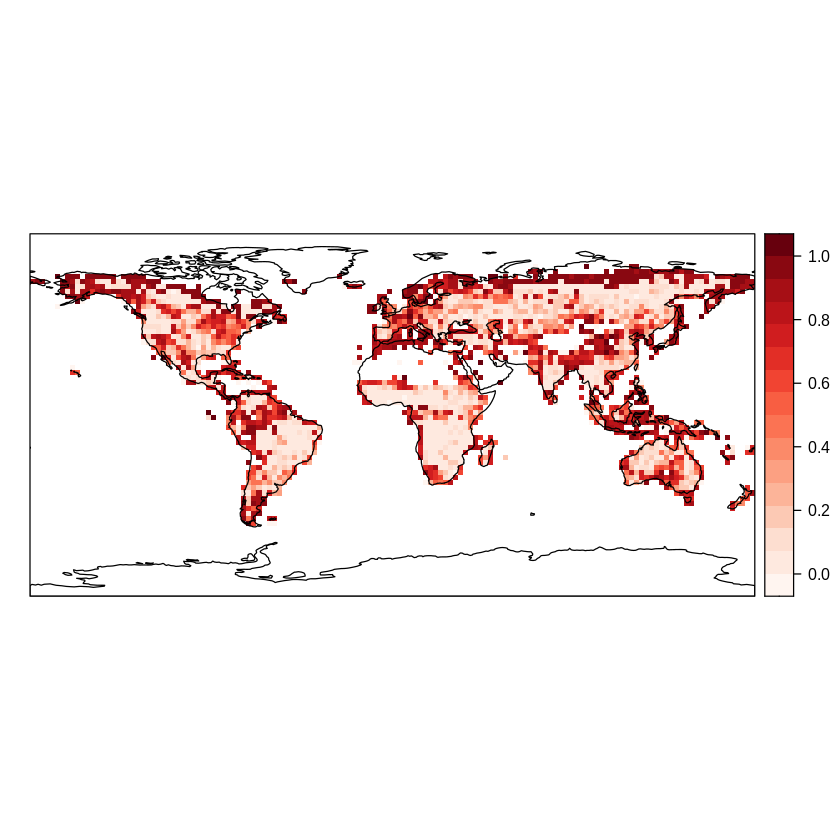

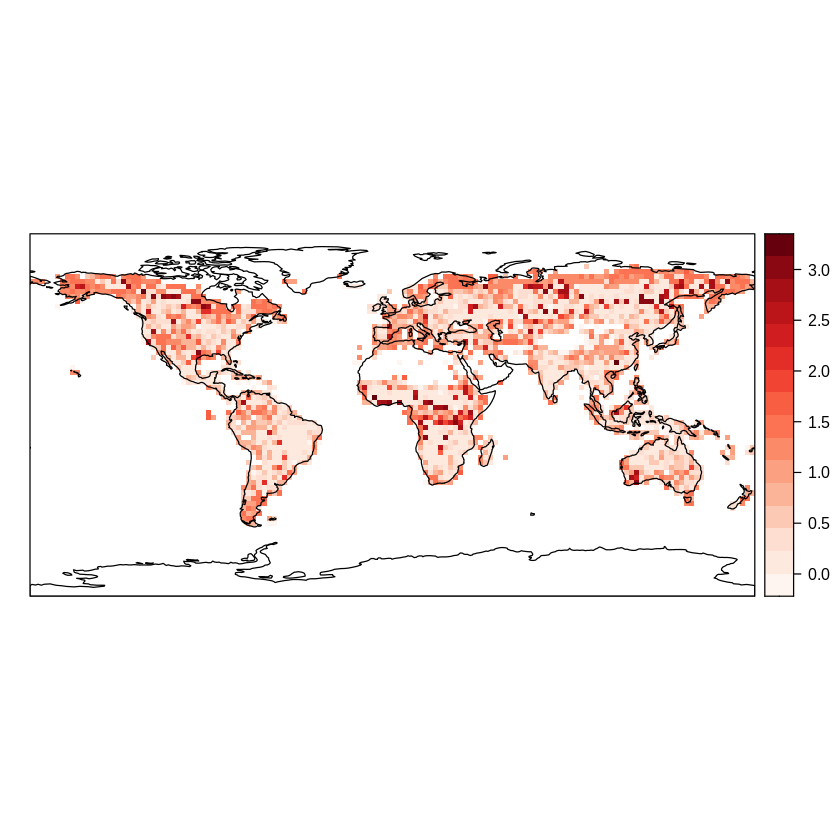

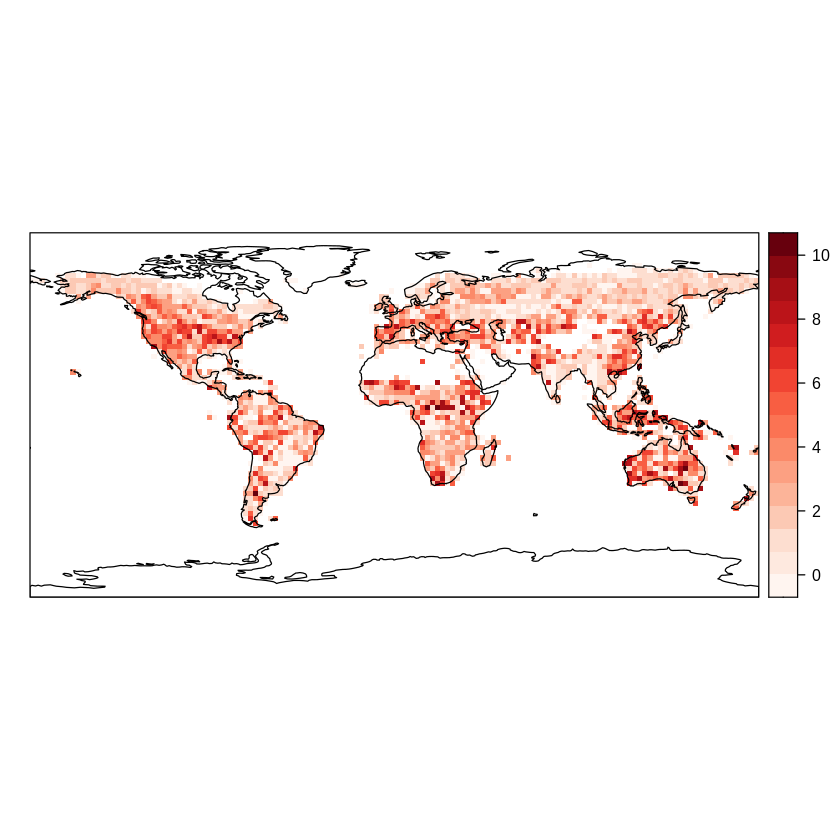

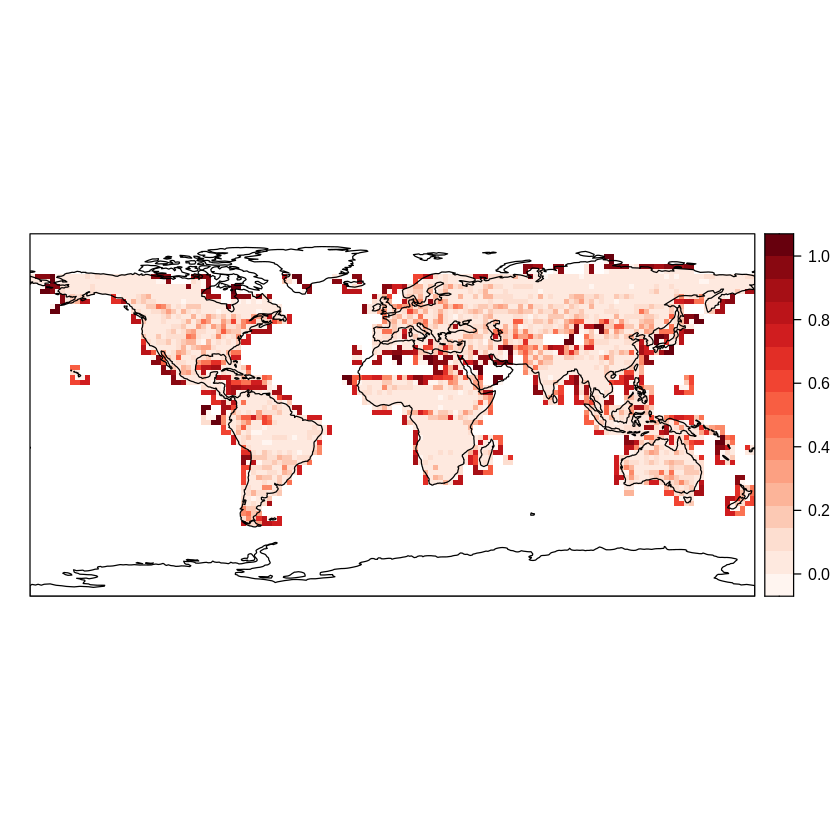

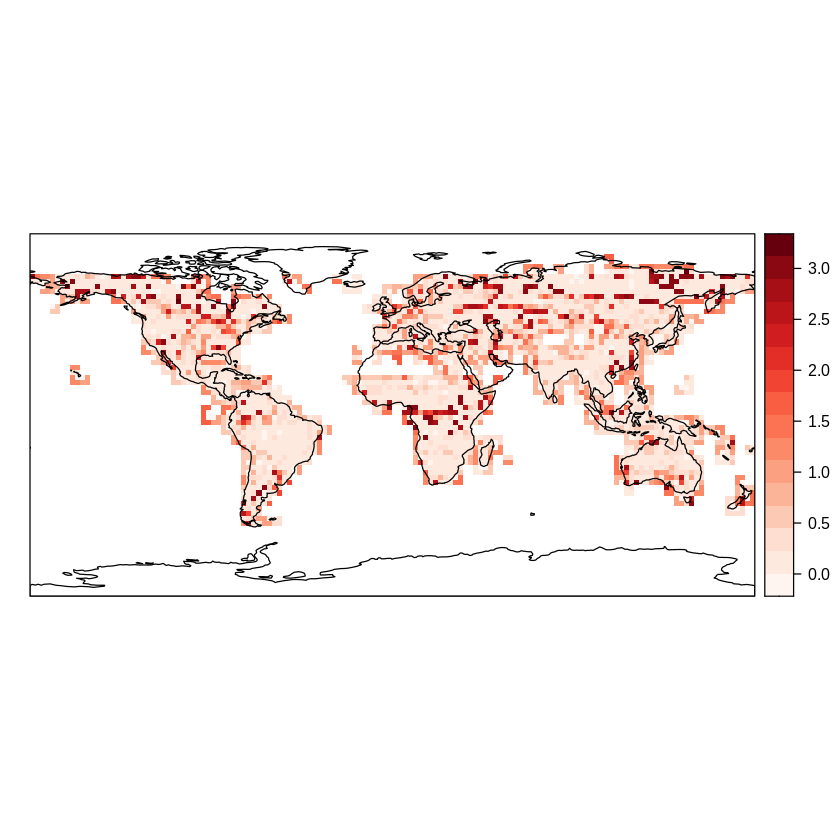

png 
  2

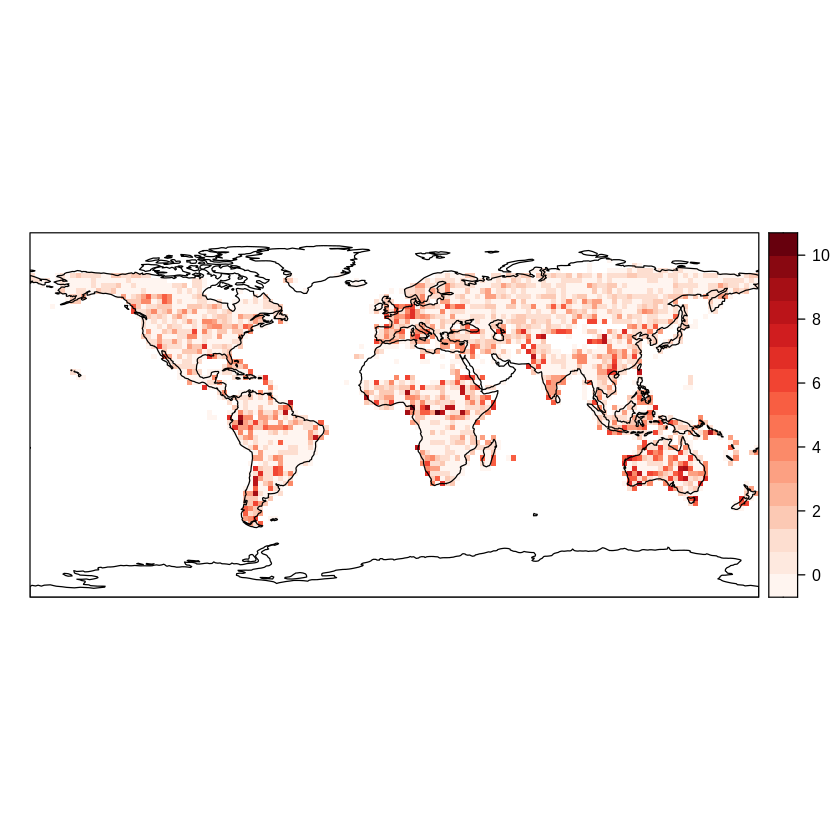

In [48]:
fig_MAE_C_clim05 <- spatialPlot(MAE_C_clim05,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_P_clim05 <- spatialPlot(MAE_P_clim05,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_L_clim05 <- spatialPlot(MAE_L_clim05,backdrop.theme = 'coastline',color.theme = "Reds")

fig_MAE_C_clim5 <- spatialPlot(MAE_C_clim5,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_P_clim5 <- spatialPlot(MAE_P_clim5,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_L_clim5 <- spatialPlot(MAE_L_clim5,backdrop.theme = 'coastline',color.theme = "Reds")

fig_MAE_C_clim05
fig_MAE_P_clim05
fig_MAE_L_clim05
fig_MAE_C_clim5
fig_MAE_P_clim5
fig_MAE_L_clim5

plotname <- "interpolacion.pdf"
pdf(plotname)
fig_MAE_C_clim05
fig_MAE_P_clim05
fig_MAE_L_clim05
fig_MAE_C_clim5
fig_MAE_P_clim5
fig_MAE_L_clim5
dev.off()

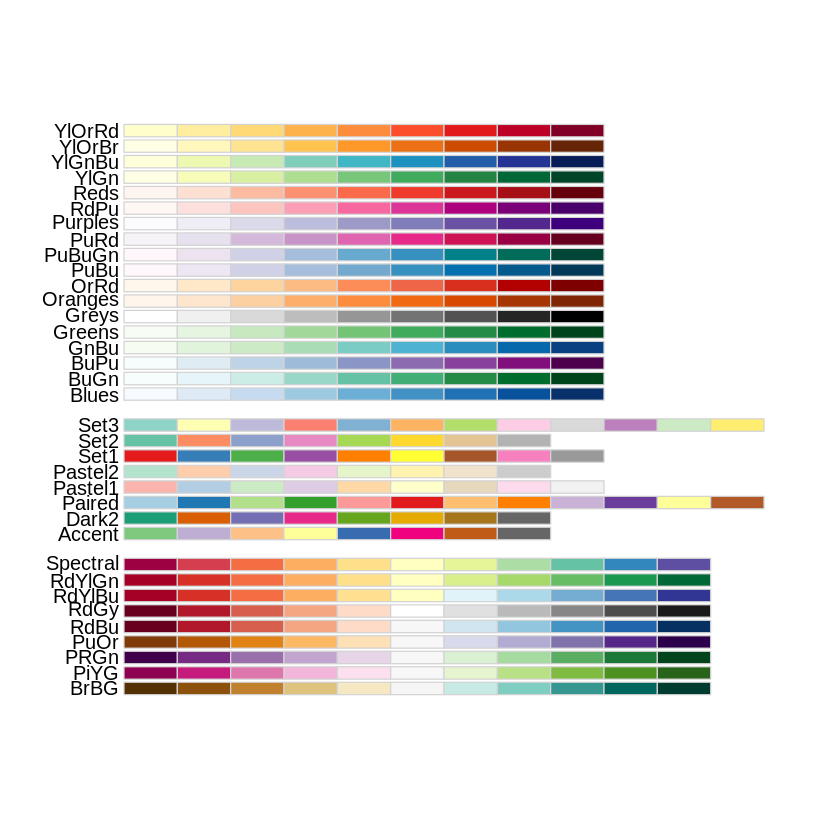

In [45]:
library(RColorBrewer)
display.brewer.all()

In [46]:
?spatialPlot

spatialPlot {visualizeR},R Documentation
grid,Input grid
backdrop.theme,Reference geographical lines to be added to the plot. See Details.
set.min,Numeric value indicating an absolute minimum value (default to NULL). All grid values below this are mapped to set.min. See details.
set.max,"Same as set.min argument, but to force a ceiling."
lonCenter,Value of the longitude to be centered in the plot (between 0 and 180).
color.theme,"A character string indicating the color theme to use in the map. Valid values are those available in the RColorBrewer themes. Additionally, the ""jet.colors"" palette can be used (the rainbow colors, in general not advised, though), for backwards compatibility. Default to the diverging, colorblind-friendly ""RdYlBu"" palette. NOTE: the color.theme argument will be overriden if the col.regions option from spplot is used."
rev.colors,"Should the chosen color theme be reversed? (default to FALSE, leaving the palette “as is”)."
...,Further arguments passed to spplot
